# PIGPVAE model

In [1]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
from torch.utils.data import Dataset, DataLoader,random_split, Subset
from tqdm import tqdm
import tsgm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
sys.path.append(os.path.abspath('..'))
from physics import NewtonsLaw
from GP import *

from Models.PIGPVAE_lognorm import PIGPVAE
from VAE_utils import AnnealingStrategy
import warnings
# Suppress only the specific GPInputWarning coming from the exact_gp.py file
warnings.filterwarnings(
    "ignore", 
    message="The input matches the stored training data. Did you forget to call model.train()?", 
    module=".*exact_gp"
)


In [2]:
# Import RICO data 
file_path = '../Data/RICO4_Dataset_processed.hdf'
df = pd.read_hdf(file_path)
#  define surrounding temperature
df.loc[:, 'sur_temp'] = (df['RTD420'] + df['RTD417'] + df['B.ASTRHT2.T'])/3 
df_h = df.copy()
df_h = df[df['temp_change_class'] == 'h']
def select_points(group):
    return group.iloc[::10]  # Select every 10th row
df_h = df_h.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)
df_h = df_h.dropna()

/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_22320/3580172856.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_h = df_h.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)


In [3]:
class RICO4Dataset(Dataset):
    def __init__(self, df, select_var, exclude_samples=None):
        """
        Args:
            df: DataFrame containing the data.
            select_var: List of variables to include in the dataset.
            exclude_samples: List of samples (intervals) to exclude from the dataset.
        """
        self.df = df
        self.select_var = select_var
        if exclude_samples:
            self.unique_batches = [batch for batch in df['interval'].unique() if batch not in exclude_samples]
        else:
            self.unique_batches = df['interval'].unique()

    def __len__(self):
        return len(self.unique_batches)

    def __getitem__(self, idx):
        batch = self.unique_batches[idx]
        temp = self.df[self.df['interval'] == batch][self.select_var]
        
        # Normalize and convert to tensors
        ti = torch.tensor(temp['time_within_interval'].to_numpy() / 240, dtype=torch.float32)
        Ts = torch.tensor(temp['sur_temp'].to_numpy(), dtype=torch.float32)
        heat_obs = torch.tensor(temp['B.RTD1'].to_numpy(), dtype=torch.float32)
        
        # Stack the tensors to create the input batch
        x_batch = torch.stack((heat_obs, Ts, ti), dim=1)
        
        return x_batch

# Initialize the dataset, excluding samples 53 and 5
exclude_samples = [53, 5]
select_var = ['time_within_interval', 'sur_temp', 'B.RTD1']
dataset = RICO4Dataset(df_h, select_var, exclude_samples=exclude_samples)

# Split the dataset into above_20 and below_20
above_20_data = []
below_20_data = []

for idx in range(len(dataset)):
    x_batch = dataset[idx]
    starting_value = x_batch[0, 0].item()  # Get the starting value of B.RTD1
    if starting_value > 20:
        above_20_data.append(x_batch)
    else:
        below_20_data.append(x_batch)

# Define SubsetDataset
class SubsetDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Create DataLoader instances
above_20_dataset = SubsetDataset(above_20_data)
below_20_dataset = SubsetDataset(below_20_data)

train_loader = DataLoader(above_20_dataset, batch_size=1, shuffle=True)  # Adjust batch_size as needed
val_loader = DataLoader(below_20_dataset, batch_size=1, shuffle=True)


In [4]:
excluded_intervals = [53, 5]
df_h_filtered = df_h[~df_h['interval'].isin(excluded_intervals)].reset_index(drop=True)
df_h = df_h_filtered


In [5]:
"""# Initialize lists to store train and validation data
train_time, train_heat = [], []
val_time, val_heat = [], []

# Collect data from train_loader
for batch in train_loader:
    # Extract `time_within_interval` and `B.RTD1` from each batch
    heat_obs = batch[0][:, 0].numpy()  # B.RTD1
    time_within_interval = batch[0][:, 2].numpy() * 240  # Convert back to original scale
    
    # Append to lists
    train_heat.extend(heat_obs)
    train_time.extend(time_within_interval)

# Collect data from val_loader
for batch in val_loader:
    # Extract `time_within_interval` and `B.RTD1` from each batch
    heat_obs = batch[0][:, 0].numpy()  # B.RTD1
    time_within_interval = batch[0][:, 2].numpy() * 240  # Convert back to original scale
    
    # Append to lists
    val_heat.extend(heat_obs)
    val_time.extend(time_within_interval)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot training data with markers only
axes[0].scatter(train_time, train_heat, marker='o', label="Train Data", alpha=0.7)
axes[0].set_title("Train Data")
axes[0].set_xlabel("Time within Interval")
axes[0].set_ylabel("B.RTD1")
axes[0].legend()

# Plot validation data with markers only
axes[1].scatter(val_time, val_heat, marker='x', label="Validation Data", alpha=0.7, color='orange')
axes[1].set_title("Validation Data")
axes[1].set_xlabel("Time within Interval")
axes[1].legend()

plt.suptitle("B.RTD1 vs Time within Interval for Train and Validation Data")
plt.show()
"""

'# Initialize lists to store train and validation data\ntrain_time, train_heat = [], []\nval_time, val_heat = [], []\n\n# Collect data from train_loader\nfor batch in train_loader:\n    # Extract `time_within_interval` and `B.RTD1` from each batch\n    heat_obs = batch[0][:, 0].numpy()  # B.RTD1\n    time_within_interval = batch[0][:, 2].numpy() * 240  # Convert back to original scale\n    \n    # Append to lists\n    train_heat.extend(heat_obs)\n    train_time.extend(time_within_interval)\n\n# Collect data from val_loader\nfor batch in val_loader:\n    # Extract `time_within_interval` and `B.RTD1` from each batch\n    heat_obs = batch[0][:, 0].numpy()  # B.RTD1\n    time_within_interval = batch[0][:, 2].numpy() * 240  # Convert back to original scale\n    \n    # Append to lists\n    val_heat.extend(heat_obs)\n    val_time.extend(time_within_interval)\n\n# Create side-by-side plots\nfig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)\n\n# Plot training data with markers only\

In [6]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5)) 

# Initialize the GP_inference
GP_inf = GP_inference(kernel)

# Initialize the VAE
torch.manual_seed(1)
model = PIGPVAE(GP_inf=GP_inf, 
                hidden_layers_encoder_delta=[10,10], 
                hidden_layers_encoder_phy=[10], 
                hidden_layers_decoder_delta=[10,10],
                activation_decoder_delta=nn.ELU(),
                initial_alpha=1.2,
                trainable_alpha=True,
                mu_prior=torch.tensor(1.7), var_prior=torch.tensor(1)
               )

In [7]:
gp_params = []
base_params = []
alpha_params = []

for name, param in model.named_parameters():
    if 'GP' in name:
        gp_params.append(param)  # Gaussian Process parameters
    elif 'raw_alpha' in name:
        alpha_params.append(param)  # raw_alpha parameter(s)
    else:
        base_params.append(param)  # All other parameters

# Define learning rates for each parameter group
base_lr = 0.001     # Learning rate for base parameters
gp_lr = 0.0001      # Learning rate for GP parameters
alpha_lr = 0.0001     # Learning rate for raw_alpha
# Create separate parameter groups in the optimizer
opt = torch.optim.Adam([
    {'params': base_params, 'lr': base_lr},
    {'params': gp_params, 'lr': gp_lr},
    {'params': alpha_params, 'lr': alpha_lr}
])
opt.zero_grad()


In [8]:
t_uni=torch.tensor(
    [  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101., 111.,
        121., 131., 141., 151., 161., 171., 181., 191., 201., 211., 221., 231.]
)

Training Progress:   5%|▍         | 49/1000 [00:03<01:00, 15.59it/s]

Epoch 50: Train Loss = 2.9976, KL_phy = 3.0149, KL_delta = -0.4434, MSE = 2.7097, CE = 1.5850, Reg_Loss = 0.0258, Alpha = 1.1945
Validation Loss = 3.5895, Val_KL_phy = 3.0478, Val_KL_delta = -0.4451, Val_MSE = 3.2395, Val_CE = 1.5322, Val_Reg_Loss = 0.0751, Val_Alpha = 1.1945


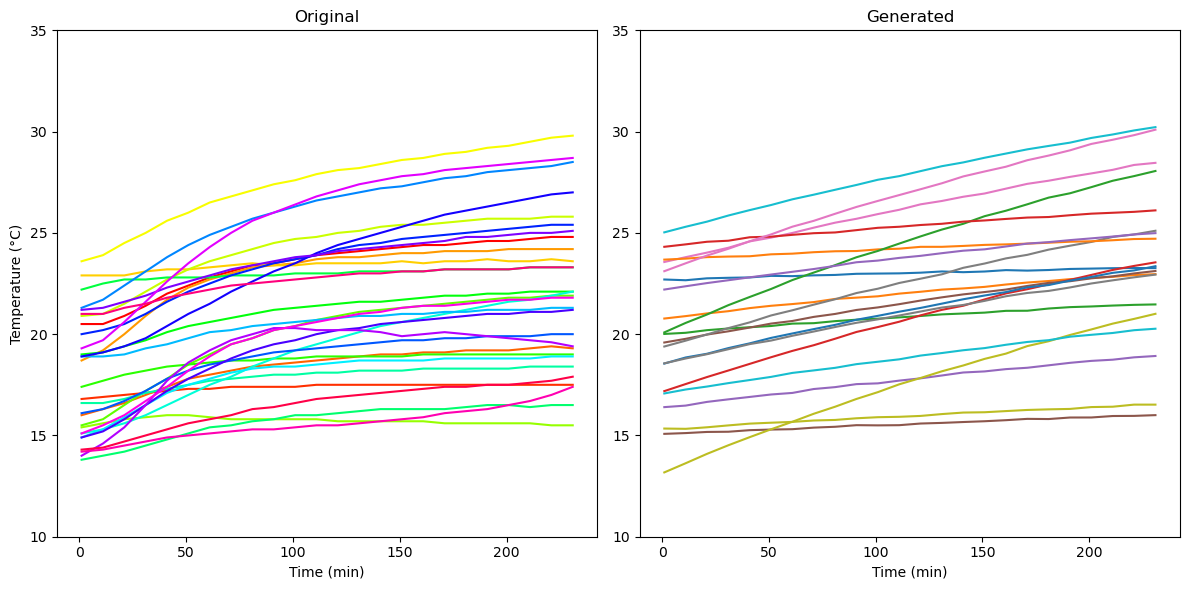

Training Progress:  10%|▉         | 99/1000 [00:06<00:58, 15.38it/s]

Epoch 100: Train Loss = 2.8345, KL_phy = 2.8823, KL_delta = -0.4289, MSE = 2.5762, CE = 1.5346, Reg_Loss = 0.0108, Alpha = 1.1896
Validation Loss = 2.7979, Val_KL_phy = 2.9067, Val_KL_delta = -0.4355, Val_MSE = 2.5108, Val_CE = 1.4943, Val_Reg_Loss = 0.0336, Val_Alpha = 1.1895


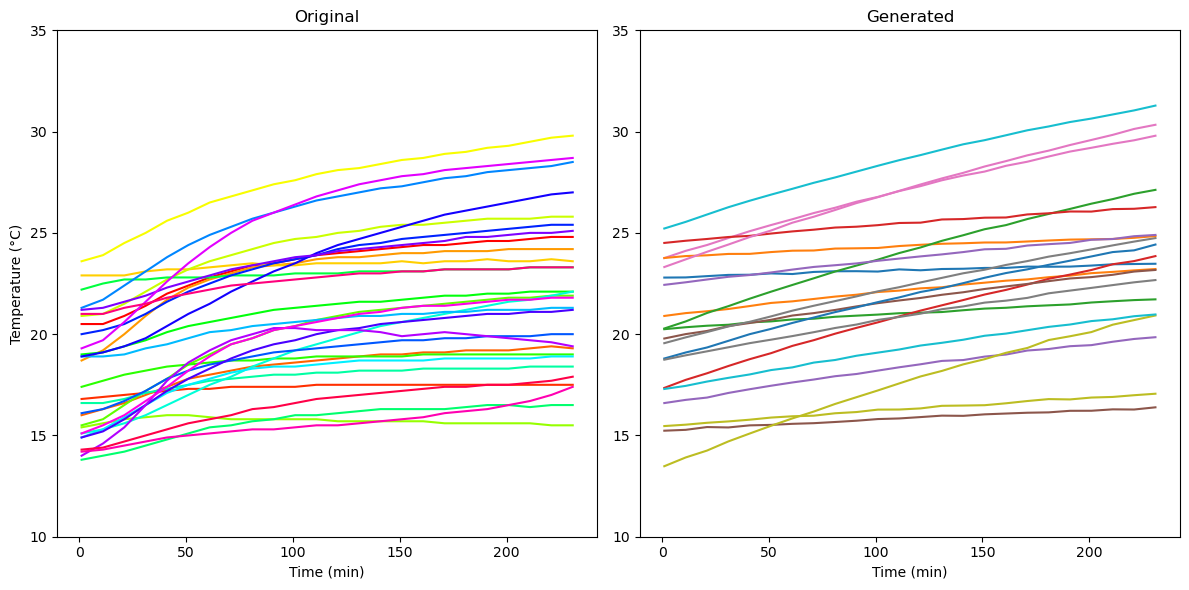

Training Progress:  15%|█▍        | 149/1000 [00:10<00:55, 15.47it/s]

Epoch 150: Train Loss = 2.8034, KL_phy = 2.7860, KL_delta = -0.4264, MSE = 2.5443, CE = 1.6014, Reg_Loss = 0.0196, Alpha = 1.1835
Validation Loss = 2.9660, Val_KL_phy = 2.8429, Val_KL_delta = -0.4356, Val_MSE = 2.6773, Val_CE = 1.5481, Val_Reg_Loss = 0.0405, Val_Alpha = 1.1834


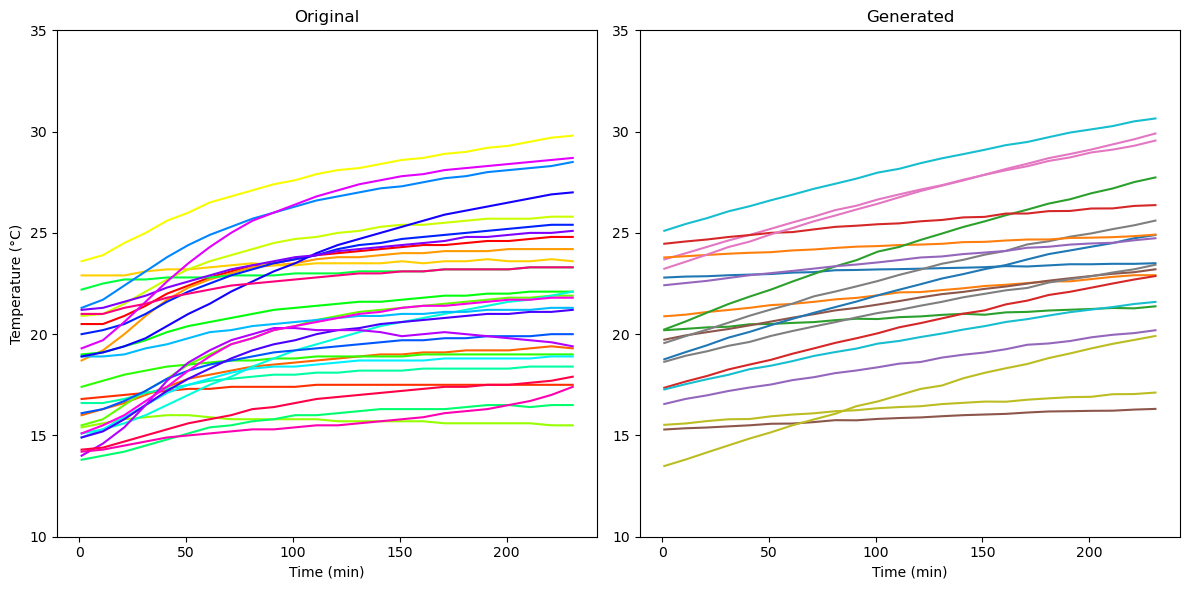

Training Progress:  20%|█▉        | 199/1000 [00:13<00:51, 15.41it/s]

Epoch 200: Train Loss = 2.7265, KL_phy = 2.8352, KL_delta = -0.4125, MSE = 2.4666, CE = 1.4532, Reg_Loss = 0.0150, Alpha = 1.1743
Validation Loss = 2.7310, Val_KL_phy = 2.8751, Val_KL_delta = -0.4235, Val_MSE = 2.4603, Val_CE = 1.4263, Val_Reg_Loss = 0.0218, Val_Alpha = 1.1742


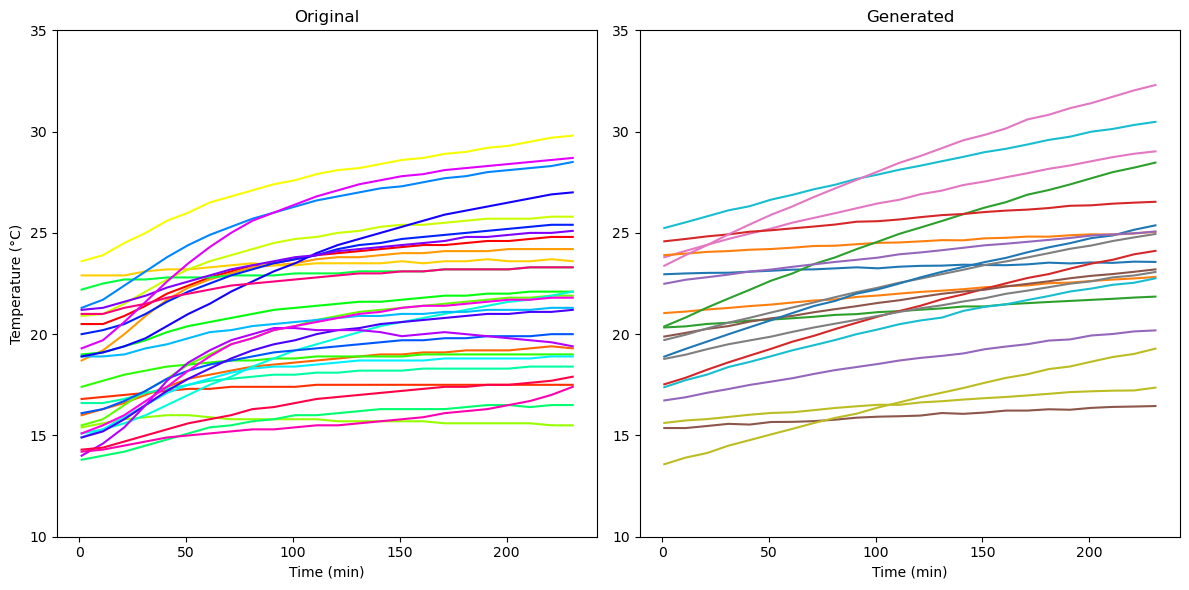

Training Progress:  25%|██▍       | 249/1000 [00:16<00:48, 15.48it/s]

Epoch 250: Train Loss = 2.6186, KL_phy = 2.7951, KL_delta = -0.3855, MSE = 2.3600, CE = 1.2172, Reg_Loss = 0.0152, Alpha = 1.1615
Validation Loss = 2.8467, Val_KL_phy = 2.8588, Val_KL_delta = -0.4039, Val_MSE = 2.5773, Val_CE = 1.2248, Val_Reg_Loss = 0.0206, Val_Alpha = 1.1614


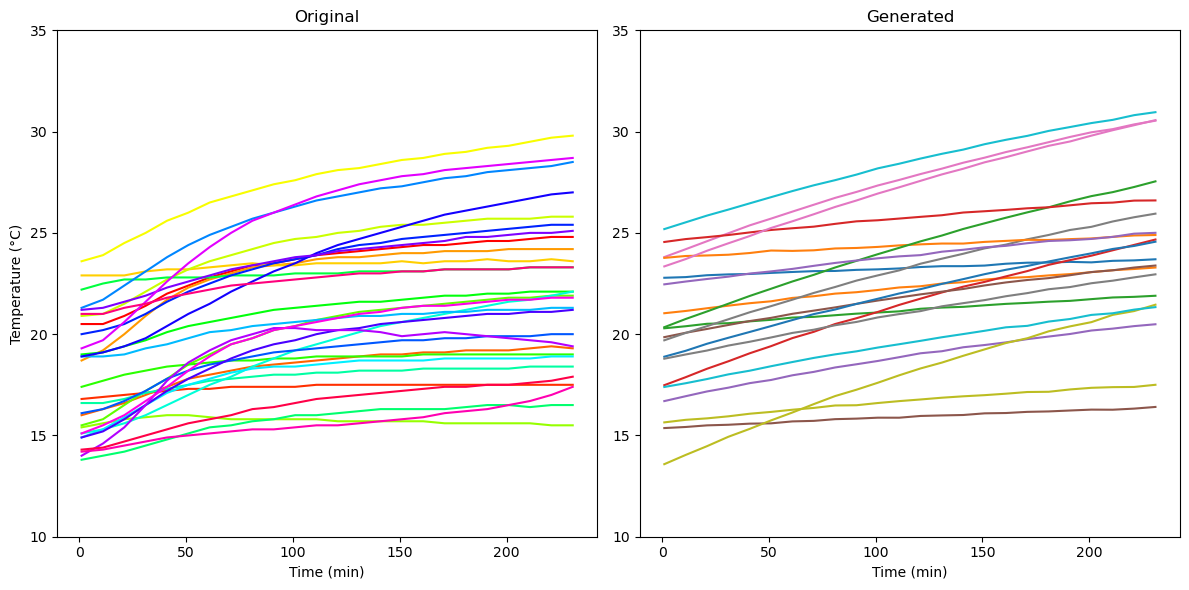

Training Progress:  30%|██▉       | 299/1000 [00:20<00:45, 15.39it/s]

Epoch 300: Train Loss = 2.4533, KL_phy = 2.7944, KL_delta = -0.3844, MSE = 2.1956, CE = 1.1836, Reg_Loss = 0.0145, Alpha = 1.1487
Validation Loss = 2.8736, Val_KL_phy = 2.8822, Val_KL_delta = -0.4028, Val_MSE = 2.6010, Val_CE = 1.1906, Val_Reg_Loss = 0.0215, Val_Alpha = 1.1486


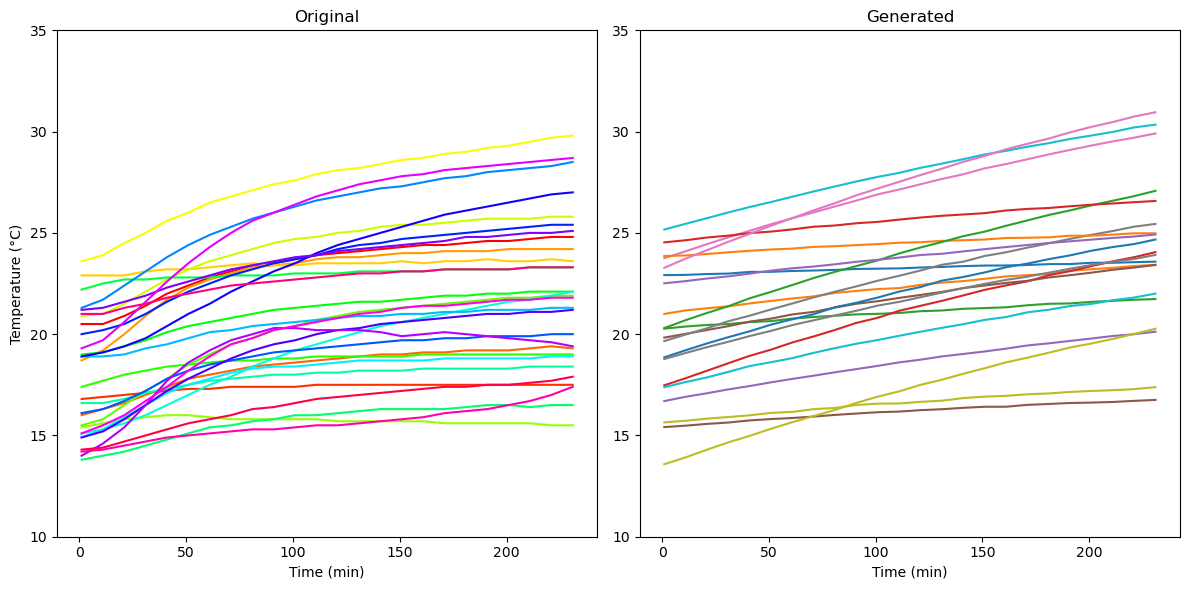

Training Progress:  35%|███▍      | 349/1000 [00:23<00:41, 15.58it/s]

Epoch 350: Train Loss = 2.3976, KL_phy = 2.8190, KL_delta = -0.3712, MSE = 2.1292, CE = 1.1794, Reg_Loss = 0.0209, Alpha = 1.1331
Validation Loss = 2.6902, Val_KL_phy = 2.9016, Val_KL_delta = -0.3942, Val_MSE = 2.4054, Val_CE = 1.2031, Val_Reg_Loss = 0.0301, Val_Alpha = 1.1329


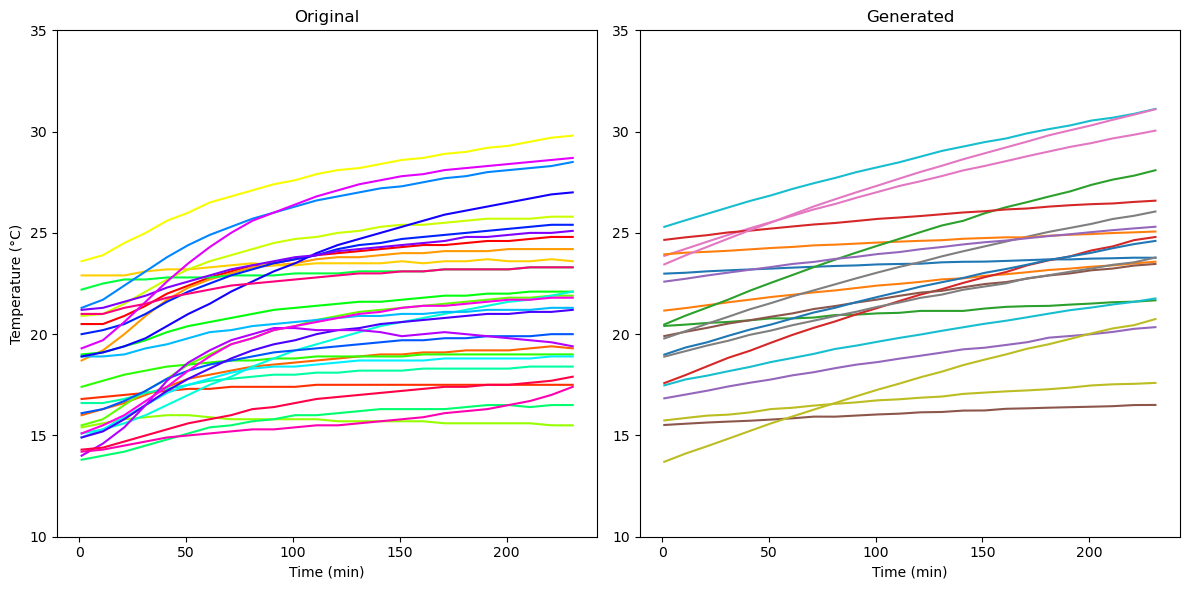

Training Progress:  40%|███▉      | 399/1000 [00:27<00:38, 15.52it/s]

Epoch 400: Train Loss = 3.0994, KL_phy = 2.8905, KL_delta = -0.3420, MSE = 2.8209, CE = 0.9737, Reg_Loss = 0.0213, Alpha = 1.1148
Validation Loss = 2.6616, Val_KL_phy = 2.9993, Val_KL_delta = -0.3734, Val_MSE = 2.3608, Val_CE = 1.0403, Val_Reg_Loss = 0.0343, Val_Alpha = 1.1147


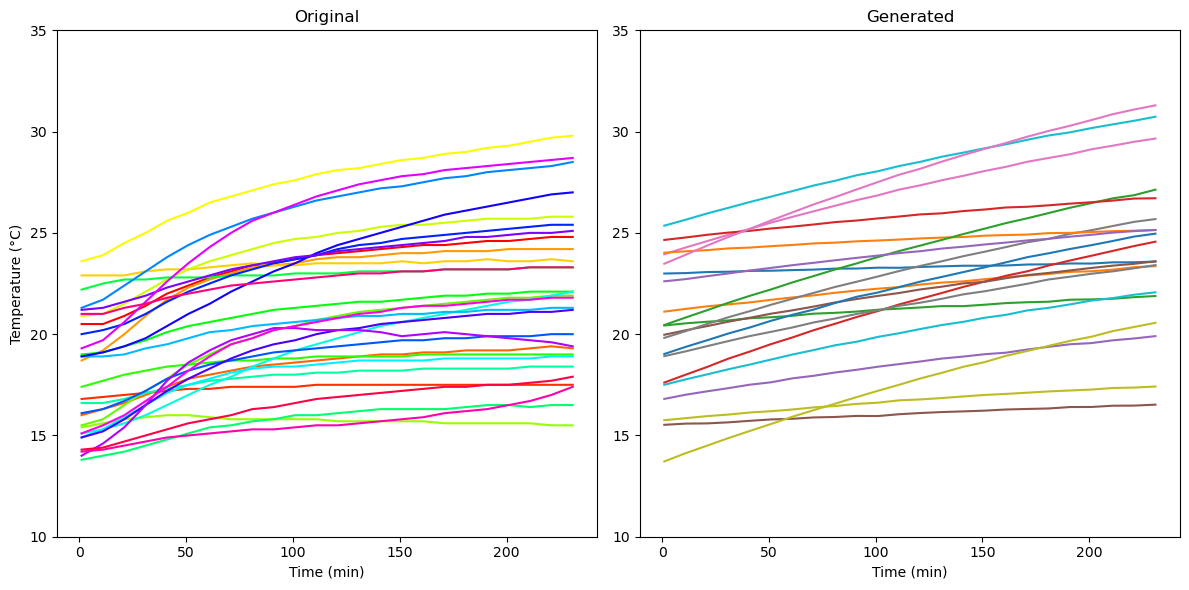

Training Progress:  45%|████▍     | 449/1000 [00:30<00:35, 15.49it/s]

Epoch 450: Train Loss = 2.7750, KL_phy = 2.8066, KL_delta = -0.2865, MSE = 2.4913, CE = 0.9284, Reg_Loss = 0.0289, Alpha = 1.0949
Validation Loss = 2.6972, Val_KL_phy = 2.9636, Val_KL_delta = -0.3451, Val_MSE = 2.4045, Val_CE = 1.0050, Val_Reg_Loss = 0.0282, Val_Alpha = 1.0947


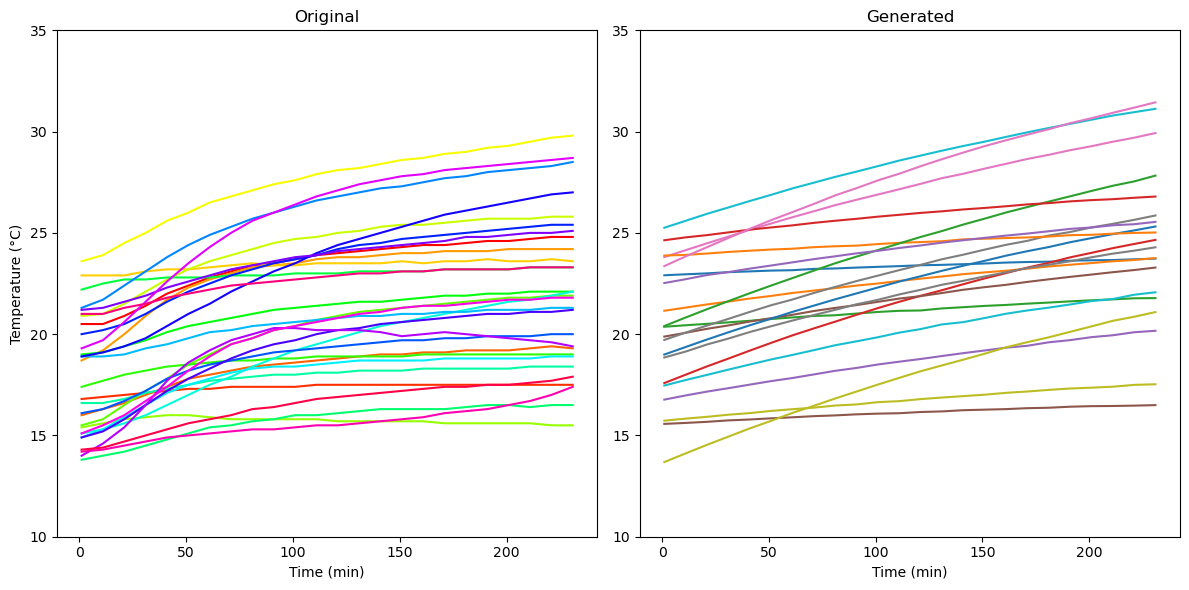

Training Progress:  50%|████▉     | 499/1000 [00:33<00:32, 15.53it/s]

Epoch 500: Train Loss = 2.6236, KL_phy = 2.8854, KL_delta = -0.2175, MSE = 2.3341, CE = 0.7695, Reg_Loss = 0.0212, Alpha = 1.0707
Validation Loss = 2.6097, Val_KL_phy = 3.0444, Val_KL_delta = -0.3004, Val_MSE = 2.2974, Val_CE = 0.8942, Val_Reg_Loss = 0.0354, Val_Alpha = 1.0705


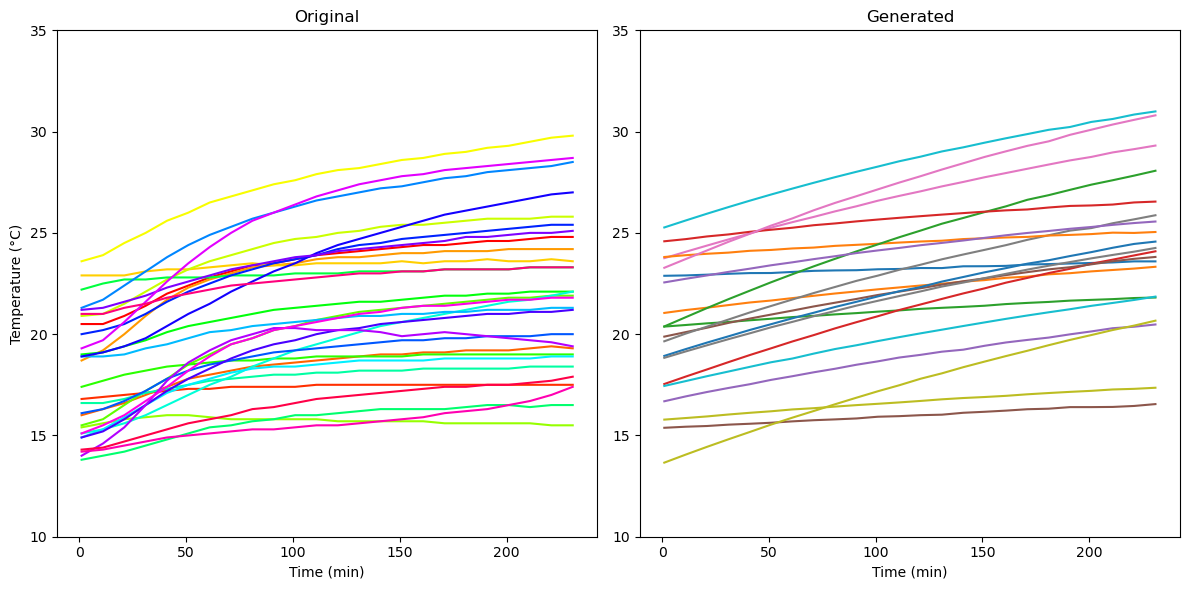

Training Progress:  55%|█████▍    | 549/1000 [00:37<00:29, 15.53it/s]

Epoch 550: Train Loss = 2.6399, KL_phy = 2.7873, KL_delta = -0.0864, MSE = 2.3218, CE = 0.5770, Reg_Loss = 0.0460, Alpha = 1.0444
Validation Loss = 2.5745, Val_KL_phy = 2.9904, Val_KL_delta = -0.2223, Val_MSE = 2.2421, Val_CE = 0.7330, Val_Reg_Loss = 0.0532, Val_Alpha = 1.0441


/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


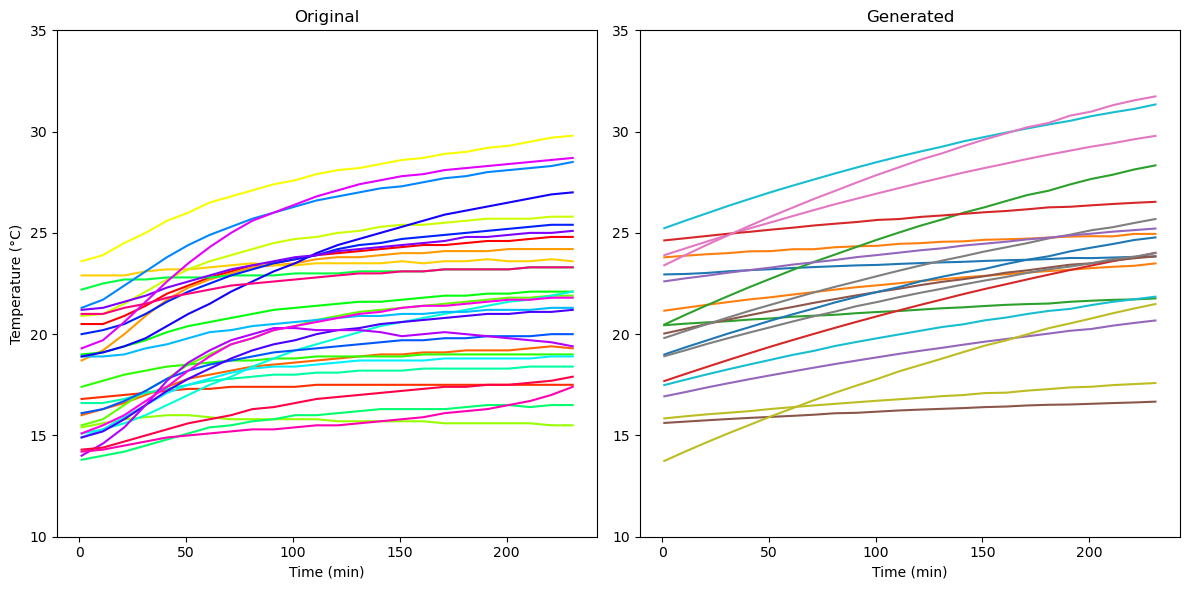

Training Progress:  60%|█████▉    | 599/1000 [00:40<00:26, 15.41it/s]

Epoch 600: Train Loss = 2.4560, KL_phy = 2.7847, KL_delta = 0.0906, MSE = 2.1254, CE = 0.2674, Reg_Loss = 0.0425, Alpha = 1.0145
Validation Loss = 2.9289, Val_KL_phy = 3.0118, Val_KL_delta = -0.1140, Val_MSE = 2.5811, Val_CE = 0.4949, Val_Reg_Loss = 0.0572, Val_Alpha = 1.0142


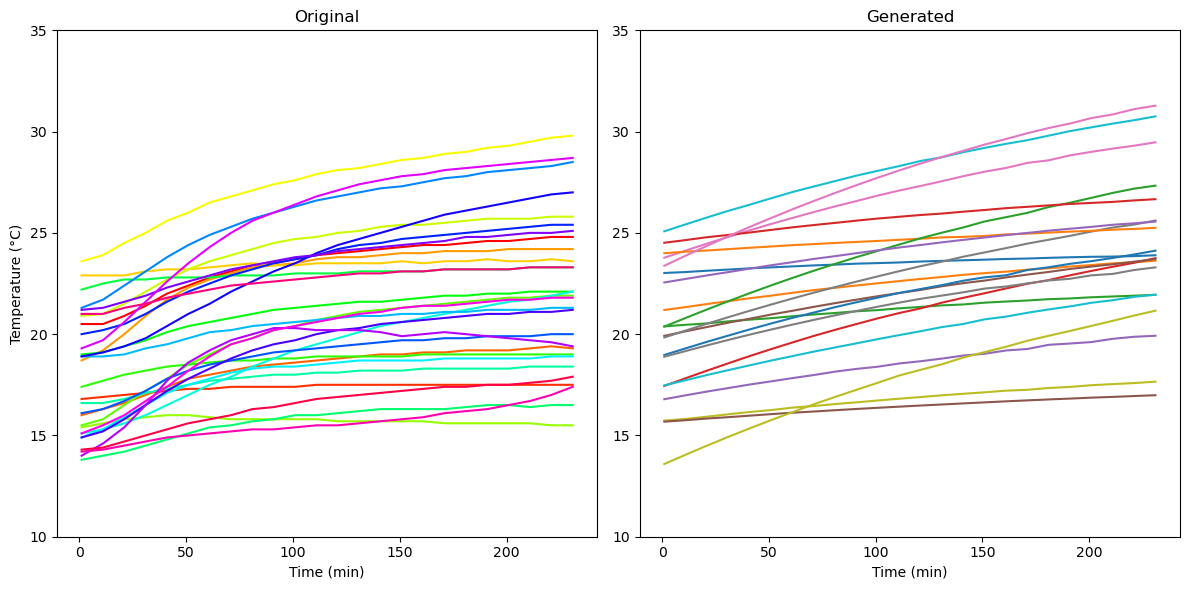

Training Progress:  65%|██████▍   | 649/1000 [00:44<00:22, 15.36it/s]

Epoch 650: Train Loss = 2.7939, KL_phy = 2.8891, KL_delta = 0.3378, MSE = 2.3601, CE = 0.1857, Reg_Loss = 0.1137, Alpha = 0.9778
Validation Loss = 2.7346, Val_KL_phy = 3.1188, Val_KL_delta = 0.0843, Val_MSE = 2.3255, Val_CE = 0.3716, Val_Reg_Loss = 0.0908, Val_Alpha = 0.9774


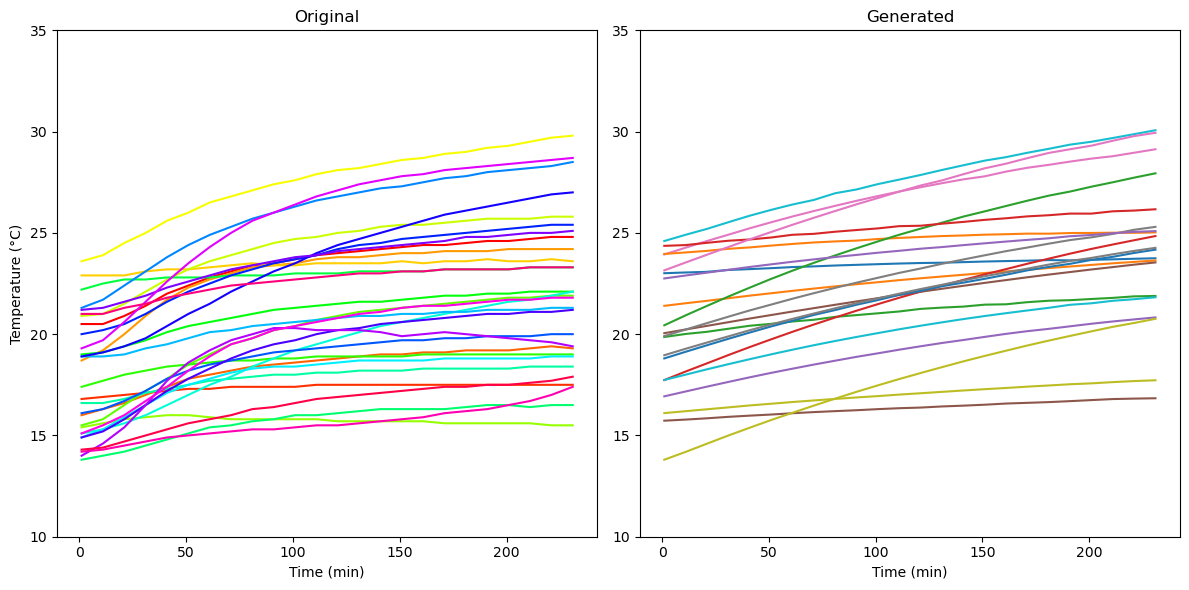

Training Progress:  70%|██████▉   | 699/1000 [00:47<00:19, 15.31it/s]

Epoch 700: Train Loss = 2.1219, KL_phy = 2.8192, KL_delta = 0.7222, MSE = 1.6509, CE = 0.1700, Reg_Loss = 0.1244, Alpha = 0.9390
Validation Loss = 2.6019, Val_KL_phy = 3.0832, Val_KL_delta = 0.3177, Val_MSE = 2.1067, Val_CE = 0.3830, Val_Reg_Loss = 0.1652, Val_Alpha = 0.9386


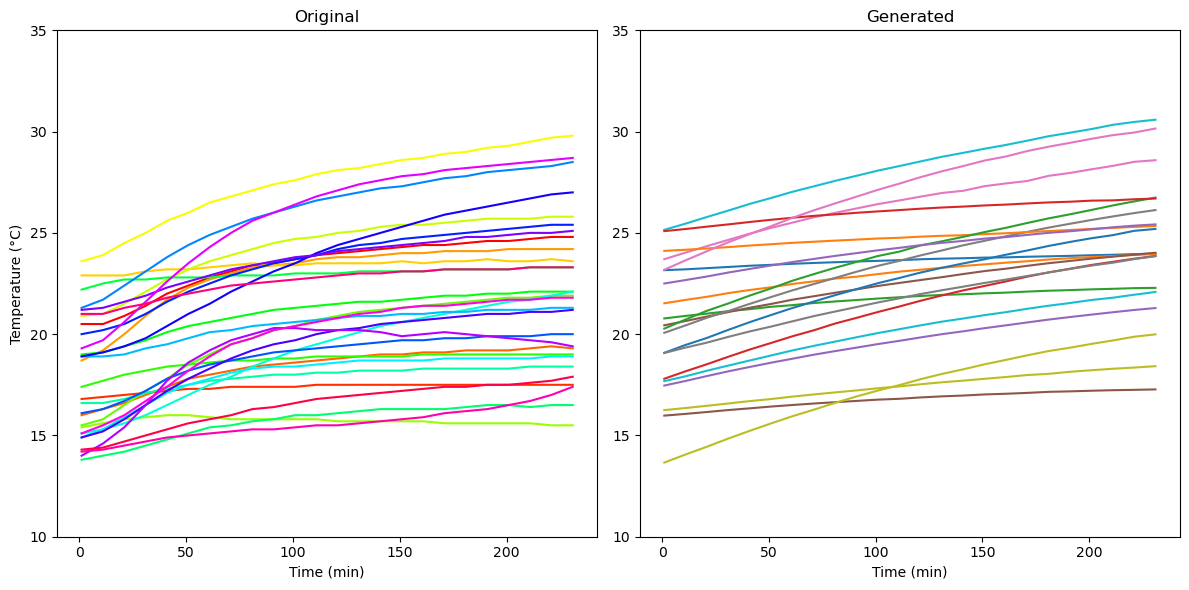

Training Progress:  75%|███████▍  | 749/1000 [00:50<00:16, 15.27it/s]

Epoch 750: Train Loss = 1.9701, KL_phy = 2.7463, KL_delta = 1.1277, MSE = 1.3937, CE = 0.0523, Reg_Loss = 0.2094, Alpha = 0.9026
Validation Loss = 2.3647, Val_KL_phy = 3.0028, Val_KL_delta = 0.5954, Val_MSE = 1.7704, Val_CE = 0.2476, Val_Reg_Loss = 0.2598, Val_Alpha = 0.9023


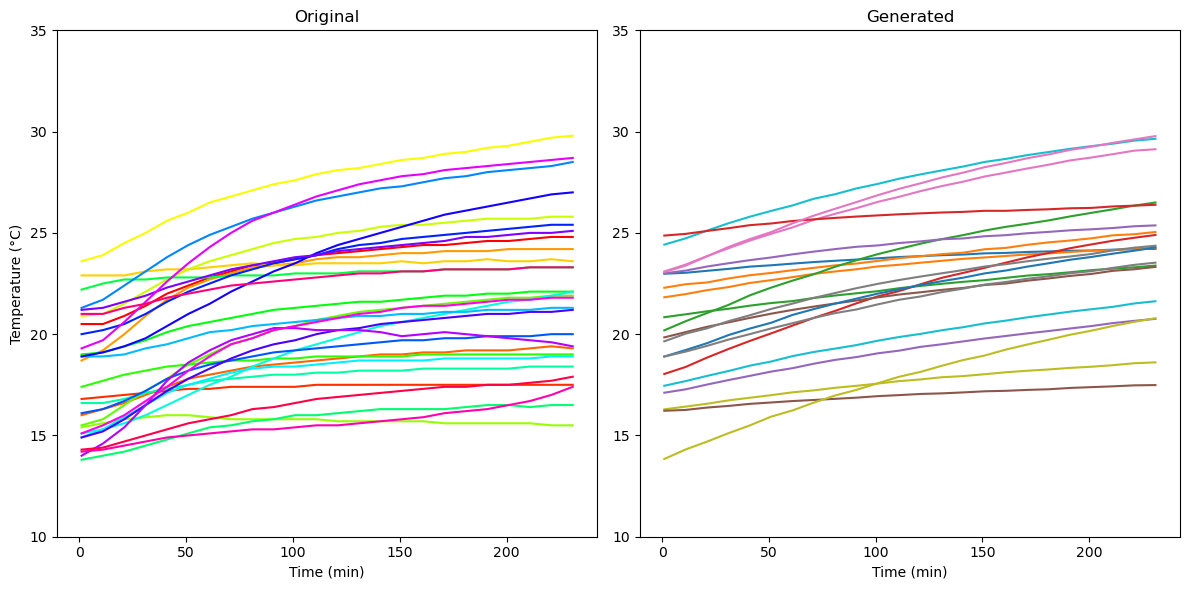

Training Progress:  80%|███████▉  | 799/1000 [00:54<00:13, 15.21it/s]

Epoch 800: Train Loss = 1.9374, KL_phy = 2.7494, KL_delta = 1.4183, MSE = 1.1964, CE = 0.0576, Reg_Loss = 0.3722, Alpha = 0.8712
Validation Loss = 2.6443, Val_KL_phy = 3.0670, Val_KL_delta = 0.7594, Val_MSE = 1.9453, Val_CE = 0.1877, Val_Reg_Loss = 0.3633, Val_Alpha = 0.8709


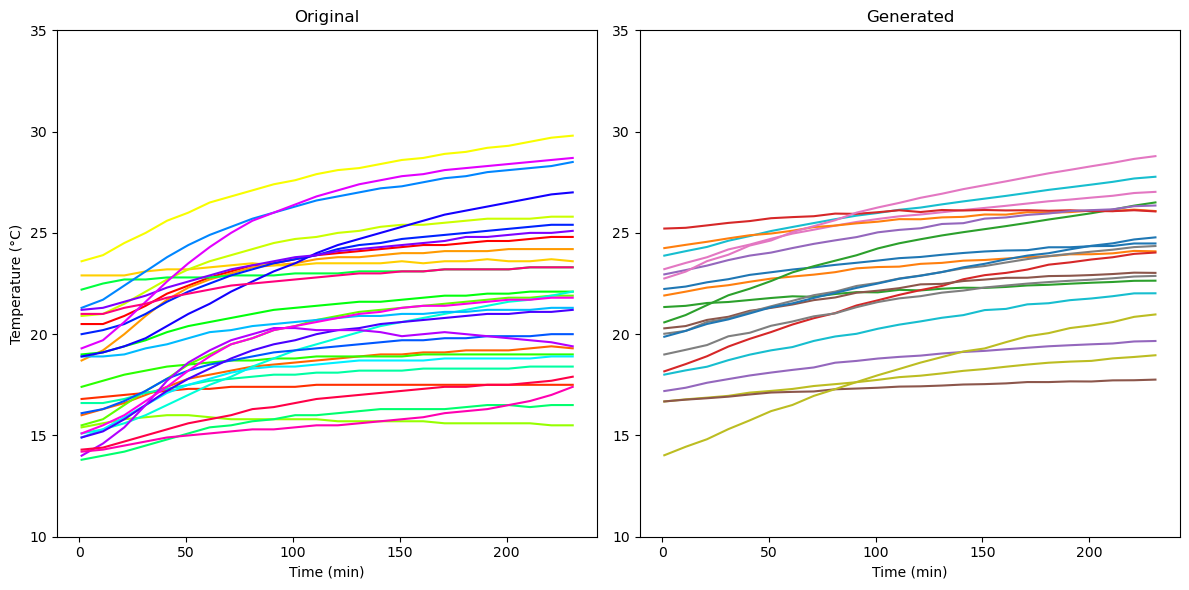

Training Progress:  85%|████████▍ | 849/1000 [00:57<00:09, 15.17it/s]

Epoch 850: Train Loss = 2.0041, KL_phy = 2.7777, KL_delta = 1.6057, MSE = 1.1652, CE = 0.0929, Reg_Loss = 0.4757, Alpha = 0.8421
Validation Loss = 2.9348, Val_KL_phy = 3.1136, Val_KL_delta = 0.8599, Val_MSE = 2.0838, Val_CE = 0.1749, Val_Reg_Loss = 0.5388, Val_Alpha = 0.8419


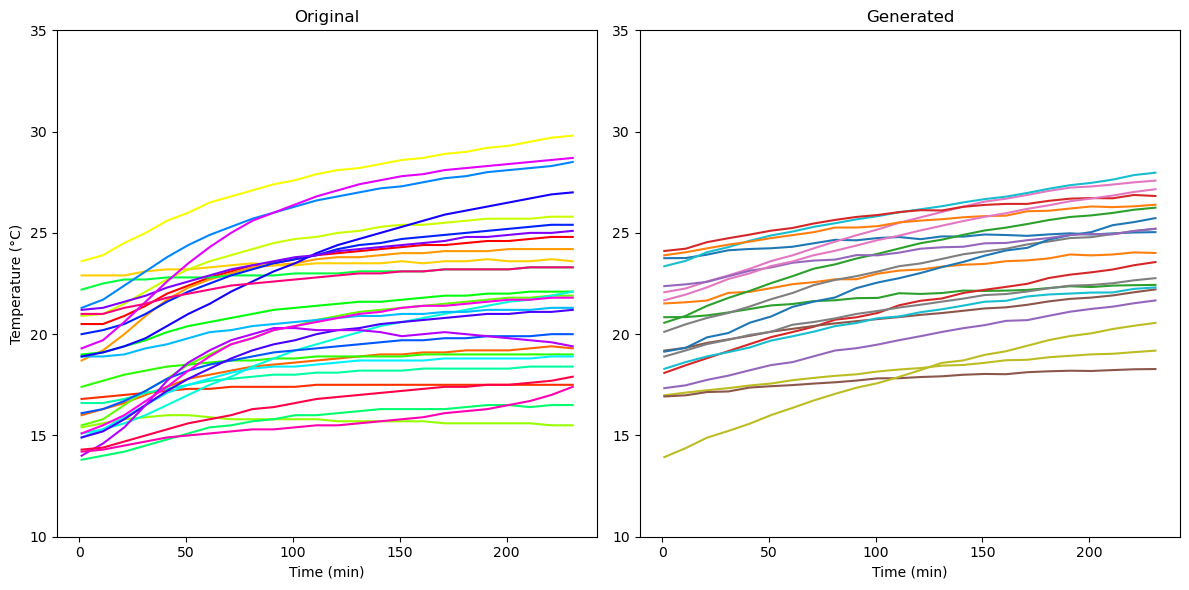

Training Progress:  90%|████████▉ | 899/1000 [01:01<00:06, 15.25it/s]

Epoch 900: Train Loss = 1.7933, KL_phy = 2.9713, KL_delta = 1.6383, MSE = 0.8845, CE = 0.0790, Reg_Loss = 0.5484, Alpha = 0.8166
Validation Loss = 2.3430, Val_KL_phy = 3.2997, Val_KL_delta = 0.9157, Val_MSE = 1.4897, Val_CE = 0.1757, Val_Reg_Loss = 0.5289, Val_Alpha = 0.8164


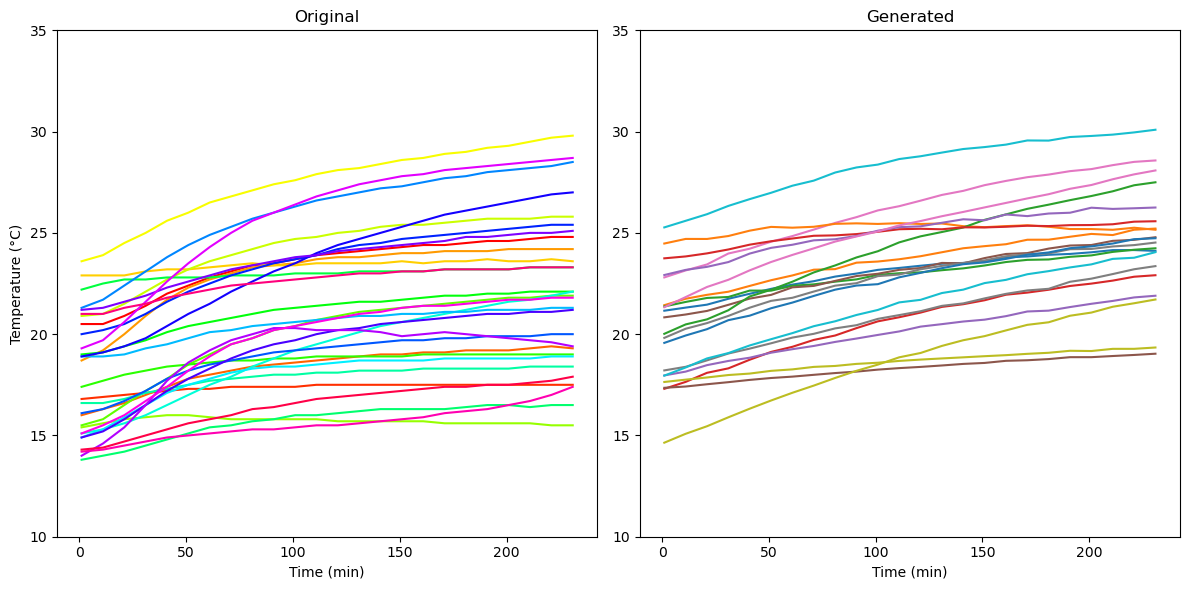

Training Progress:  95%|█████████▍| 949/1000 [01:04<00:03, 15.12it/s]

Epoch 950: Train Loss = 1.5570, KL_phy = 2.7912, KL_delta = 1.5472, MSE = 0.7072, CE = 0.0702, Reg_Loss = 0.5238, Alpha = 0.7941
Validation Loss = 2.3886, Val_KL_phy = 3.1784, Val_KL_delta = 0.8553, Val_MSE = 1.5713, Val_CE = 0.1763, Val_Reg_Loss = 0.5213, Val_Alpha = 0.7939


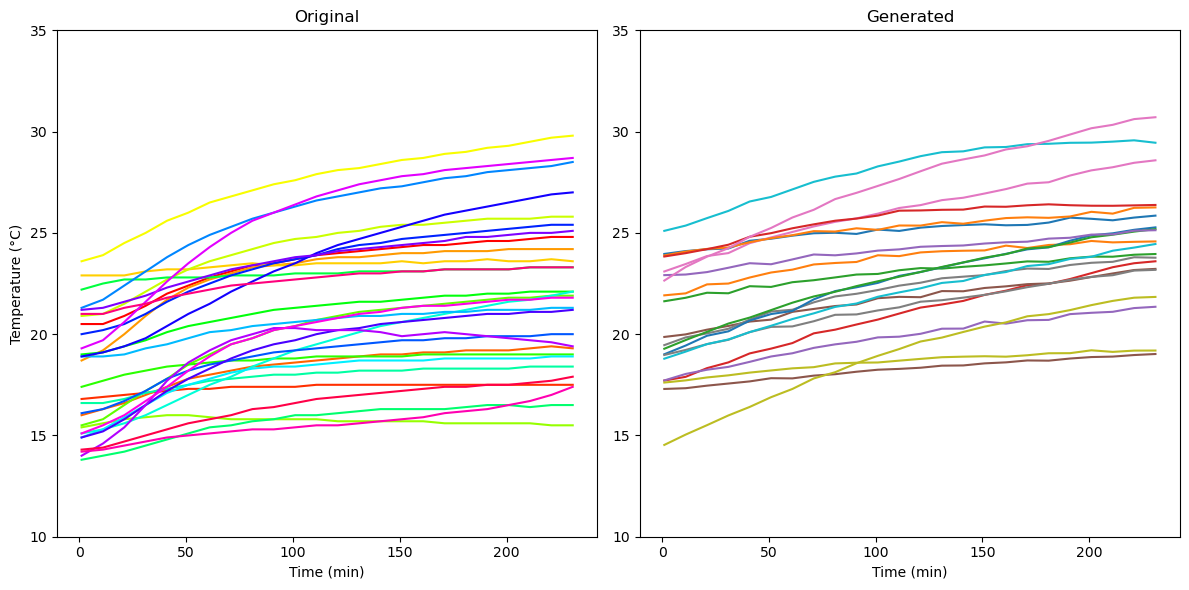

Training Progress: 100%|█████████▉| 999/1000 [01:08<00:00, 15.14it/s]

Epoch 1000: Train Loss = 1.6918, KL_phy = 2.8686, KL_delta = 1.4527, MSE = 0.7600, CE = 0.0680, Reg_Loss = 0.6451, Alpha = 0.7746
Validation Loss = 2.3210, Val_KL_phy = 3.2565, Val_KL_delta = 0.7957, Val_MSE = 1.5378, Val_CE = 0.1822, Val_Reg_Loss = 0.4881, Val_Alpha = 0.7744


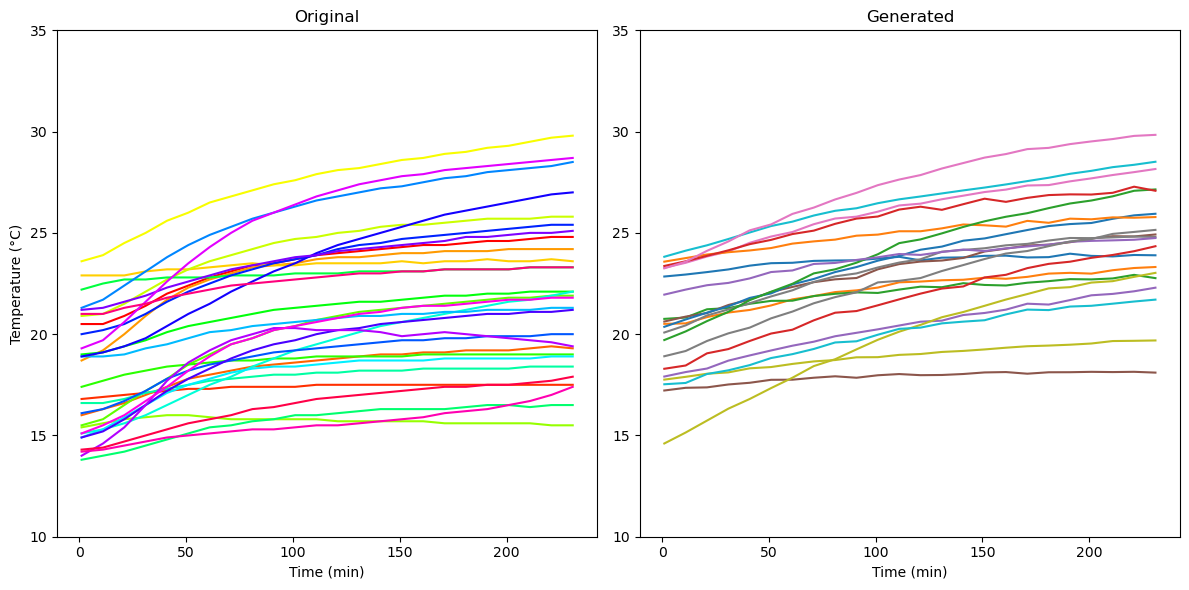

Training Progress: 100%|██████████| 1000/1000 [01:08<00:00, 14.66it/s]


In [9]:
num_epochs=1000
epochs=range(num_epochs)

annealing_strategy = AnnealingStrategy(strategy='linear', 
                                       total_epochs=num_epochs, 
                                       beta_min=0.1, 
                                       beta_max=0.1)
beta_annealed = annealing_strategy.get_beta_vector()

beta_delta=beta_annealed
beta_phy=beta_annealed
ns = 20
min_T, max_T = 12, 25
T0 = min_T + (max_T - min_T) * torch.rand(ns)
difference = 1 + (20 - 1) * torch.rand(ns)
Ts = T0 + difference
unique_intervals = df_h['interval'].unique()
num_unique_intervals = len(unique_intervals)

fit_res = model.fit(train_loader=train_loader, 
                    val_loader=val_loader, 
                    opt=opt, 
                    beta_delta=beta_delta,
                    beta_phy=beta_phy,
                    num_epochs=num_epochs,
                   seed=0, plot=True, df=df_h, ns=ns, T0=T0, Ts=Ts, t_uni=t_uni/240, axs_ylim=(10, 35))


In [ ]:
# torch.save(model.state_dict(), 'pre_trained_models/PIGPVAE_heating.pth')